In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')

In [3]:
sys.path.insert(1,'../../scripts/optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

In [6]:
sensitivity_results_path = os.path.join('../../results/plant_optimization/540a4d2_sensitivity/onshore') # Points to the location of the results csv files
results_path = os.path.join('../../results/plant_optimization/ec6297d_2050/onshore') # Points to the location of the results csv files

In [7]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs = specs.dropna(how='all')
specs_names = specs.index

In [8]:
eval_param = [
'CO2_OPEX',
'battery_c_rate',
'heat_lifetime',
'battery_lifetime',
'CO2stor_OPEX',
'CO2_el_efficiency',
'heat_CAPEX',
'H2tL_CAPEX',
'battery_cycle_efficiency',
'electrolyzer_lifetime',
'battery_OPEX',
'H2stor_OPEX',
'PV_OPEX',
'H2tL_OPEX',
'electrolyzer_OPEX',
'battery_CAPEX',
'CO2_lifetime',
'CO2_th_efficiency',
'wind_OPEX',
'H2stor_CAPEX',
'CO2stor_CAPEX',
'CO2_CAPEX',
'PV_CAPEX',
'electrolyzer_CAPEX',
'wind_lifetime',
'H2tL_baseload',
'discount_rate',
'wind_CAPEX',
'electrolyzer_efficiency',
'H2tL_chem_efficiency'
]

# Load Results

In [9]:
# Load all sensitivity results files into a single dataframe
sensitivity = pd.DataFrame()
for file_glob in glob(f'{sensitivity_results_path}/sensitivity*.csv'): 
    sensitivity = sensitivity.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    
# Load all optimization results (with 2050 parameters) into a single dataframe
countries = europe_grid.country.unique()
results_2050_raw = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results_2050_raw = results_2050_raw.append(df) 
results_2050 = results_2050_raw.drop(columns=[x for x in specs_names if x in results_2050_raw.columns])

# Merge the above two dataframes
combined = gpd.GeoDataFrame(sensitivity.merge(results_2050,on=['lat','lon','country','shore_designation'],how='left',suffixes=('_sensi','_2050')))
combined['sea_node'] = combined.apply(lambda x: True if x.shore_designation=='offshore' else False, axis=1)
combined_gdf = gpd.GeoDataFrame(combined.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]

# Normalize all parameter values
for eval_param in eval_params:
    combined_gdf[eval_param] = combined_gdf[eval_param]/specs.at[eval_param,'value_2050']

# Normalize the LCOF found in the sensitivty analysis relative to that found for the 2050 parameters
combined_gdf['LCOF_liter_norm'] = combined_gdf.LCOF_liter_sensi/combined_gdf.LCOF_liter_2050

# Set wind column based on turbine class
combined_gdf['wind_CAPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_CAPEX'],axis=1)
combined_gdf['wind_OPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_OPEX'],axis=1)
combined_gdf.drop(columns=['wind_lo_CAPEX','wind_lo_OPEX','wind_mid_CAPEX','wind_mid_OPEX','wind_hi_CAPEX','wind_hi_OPEX','wind_monopole_CAPEX','wind_monopole_OPEX','wind_jacket_CAPEX','wind_jacket_OPEX','wind_floating_CAPEX','wind_floating_OPEX'],
                  inplace=True)

# Remove outliers
z_score_filter = 3
prev_len = len(combined_gdf)
mask = abs(combined_gdf.LCOF_liter_norm.mean()-combined_gdf.LCOF_liter_norm)<z_score_filter*combined_gdf.LCOF_liter_norm.std()
combined_gdf = combined_gdf.loc[mask]
print(f'{prev_len-len(combined_gdf)} outlier entries were dropped.')

0 outlier entries were dropped.


# Identify correlations

In [10]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg = pd.DataFrame()
n_digits = 2
for eval_param in eval_params:
    X = combined_gdf[eval_param]
    Y = combined_gdf.LCOF_liter_norm
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg = ols_reg.append({
        'Parameter':eval_param,
        'Intercept':results.params.const,
        'Intercept 95% C.I.':f'[{round(results.conf_int().loc["const"][0],n_digits):+.2f},{round(results.conf_int().loc["const"][1],n_digits):+.2f}]',
        'Slope':results.params[eval_param],
        'Slope 95% C.I.':f'[{round(results.conf_int().loc[eval_param][0],n_digits):+.2f},{round(results.conf_int().loc[eval_param][1],n_digits):+.2f}]',
        'R-Squared':results.rsquared,
        'Slope P-Value': results.pvalues[eval_param]
        
#         'rsquared_adj':results.rsquared_adj
    },ignore_index=True)
ols_reg = ols_reg[['Parameter','Slope','Slope 95% C.I.','Intercept','Intercept 95% C.I.','R-Squared', 'Slope P-Value']]

In [24]:
combined_gdf['discount_rate']

0     0.05
1     0.05
2     0.05
3     0.05
4     0.05
      ... 
95    0.05
96    0.05
97    0.05
98    0.05
99    0.05
Name: discount_rate, Length: 100, dtype: float64

In [22]:
[x for x in eval_params if combined_gdf[x].max()==combined_gdf[x].min()]

['CO2_OPEX',
 'CO2_el_efficiency',
 'CO2_max_capacity',
 'CO2_min_capacity',
 'CO2_th_efficiency',
 'CO2stor_OPEX',
 'CO2stor_lifetime',
 'CO2stor_max_capacity',
 'CO2stor_min_capacity',
 'H2stor_OPEX',
 'H2stor_lifetime',
 'H2stor_max_capacity',
 'H2stor_min_capacity',
 'H2tL_OPEX',
 'H2tL_baseload',
 'H2tL_el_demand',
 'H2tL_heat_output',
 'H2tL_lifetime',
 'H2tL_max_capacity',
 'H2tL_min_capacity',
 'H2tL_required_CO2',
 'PV_OPEX',
 'PV_lifetime',
 'PV_max_capacity',
 'PV_min_capacity',
 'PV_peak_per_area',
 'battery_OPEX',
 'battery_c_rate',
 'battery_cycle_efficiency',
 'battery_lifetime',
 'battery_max_capacity',
 'battery_min_capacity',
 'diesel_LHV',
 'diesel_energy_fraction',
 'discount_rate',
 'electrolyzer_OPEX',
 'electrolyzer_baseload',
 'electrolyzer_lifetime',
 'electrolyzer_max_capacity',
 'electrolyzer_min_capacity',
 'electrolyzer_stack_CAPEX',
 'electrolyzer_stack_lifetime',
 'gasoline_LHV',
 'gasoline_energy_fraction',
 'heat_CAPEX',
 'heat_OPEX',
 'heat_el_efficien

In [21]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
# eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
# eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
eval_params

['CO2_CAPEX',
 'CO2_OPEX',
 'CO2_el_efficiency',
 'CO2_lifetime',
 'CO2_max_capacity',
 'CO2_min_capacity',
 'CO2_th_efficiency',
 'CO2stor_CAPEX',
 'CO2stor_OPEX',
 'CO2stor_lifetime',
 'CO2stor_max_capacity',
 'CO2stor_min_capacity',
 'H2stor_CAPEX',
 'H2stor_OPEX',
 'H2stor_lifetime',
 'H2stor_max_capacity',
 'H2stor_min_capacity',
 'H2tL_CAPEX',
 'H2tL_OPEX',
 'H2tL_baseload',
 'H2tL_chem_efficiency',
 'H2tL_el_demand',
 'H2tL_heat_output',
 'H2tL_lifetime',
 'H2tL_max_capacity',
 'H2tL_min_capacity',
 'H2tL_required_CO2',
 'PV_CAPEX',
 'PV_OPEX',
 'PV_lifetime',
 'PV_max_capacity',
 'PV_min_capacity',
 'PV_peak_per_area',
 'battery_CAPEX',
 'battery_OPEX',
 'battery_c_rate',
 'battery_cycle_efficiency',
 'battery_lifetime',
 'battery_max_capacity',
 'battery_min_capacity',
 'diesel_LHV',
 'diesel_energy_fraction',
 'discount_rate',
 'electrolyzer_CAPEX',
 'electrolyzer_OPEX',
 'electrolyzer_baseload',
 'electrolyzer_efficiency',
 'electrolyzer_lifetime',
 'electrolyzer_max_capacit

In [15]:
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True)

,Parameter,Slope,Slope 95% C.I.,Intercept,Intercept 95% C.I.,R-Squared,Slope P-Value
0,H2tL_chem_efficiency,-1.085738,"[-1.27,-0.90]",2.154094,"[+1.96,+2.34]",0.576284,5.603073e-20
1,electrolyzer_efficiency,-0.585571,"[-0.86,-0.31]",1.657463,"[+1.38,+1.94]",0.156129,4.732004e-05
2,electrolyzer_CAPEX,0.295910,"[+0.02,+0.58]",0.778878,"[+0.50,+1.06]",0.043220,3.793766e-02
3,wind_CAPEX,0.334298,"[+0.02,+0.65]",0.738986,"[+0.42,+1.06]",0.042875,3.872808e-02
4,H2tL_CAPEX,-0.317811,"[-0.66,+0.02]",1.379424,"[+1.04,+1.72]",0.033859,6.685869e-02
5,CO2_CAPEX,0.266024,"[-0.03,+0.56]",0.808812,"[+0.52,+1.10]",0.032457,7.287211e-02
6,battery_CAPEX,0.243465,"[-0.06,+0.55]",0.837173,"[+0.54,+1.13]",0.025433,1.129936e-01
7,PV_CAPEX,0.251921,"[-0.09,+0.59]",0.810859,"[+0.46,+1.17]",0.021764,1.429923e-01
8,CO2stor_CAPEX,0.214575,"[-0.14,+0.57]",0.851623,"[+0.48,+1.22]",0.014418,2.340531e-01
9,H2stor_CAPEX,0.090560,"[-0.24,+0.42]",0.983456,"[+0.66,+1.31]",0.002973,5.900277e-01


In [12]:
latex_table = ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True)
latex_table['Slope'] = np.round(latex_table['Slope'],3)
latex_table['Intercept'] = np.round(latex_table['Intercept'],3)
latex_table['R^2 x100'] = np.round(latex_table['R-Squared']*100,2)
latex_table.drop(columns=['R-Squared'], inplace=True)

param_name_map = {
    'H2tL_chem_efficiency': 'Fuel synthesis chemical efficiency',
    'electrolyzer_efficiency': 'Electrolyser efficiency',
    'wind_CAPEX': 'Wind CAPEX',
    'discount_rate': 'Discount rate',
    'H2tL_baseload': 'Fuel synthesis baseload',
    'wind_lifetime': 'Wind lifetime',
    'electrolyzer_CAPEX': 'Electrolyser CAPEX',
    'PV_CAPEX': 'Solar PV CAPEX',
    'CO2_CAPEX': 'DAC CAPEX',
}

latex_table['Variable name'] = latex_table['Parameter']
latex_table['Parameter'] = latex_table['Variable name'].map(param_name_map)
latex_table = latex_table[['Parameter','Variable name','Slope','Slope 95% C.I.','Intercept','Intercept 95% C.I.','R^2 x100']]
latex_table.head(9)

,Parameter,Variable name,Slope,Slope 95% C.I.,Intercept,Intercept 95% C.I.,R^2 x100
0,Fuel synthesis chemical efficiency,H2tL_chem_efficiency,-1.086,"[-1.27,-0.90]",2.154,"[+1.96,+2.34]",57.63
1,Electrolyser efficiency,electrolyzer_efficiency,-0.586,"[-0.86,-0.31]",1.657,"[+1.38,+1.94]",15.61
2,Electrolyser CAPEX,electrolyzer_CAPEX,0.296,"[+0.02,+0.58]",0.779,"[+0.50,+1.06]",4.32
3,Wind CAPEX,wind_CAPEX,0.334,"[+0.02,+0.65]",0.739,"[+0.42,+1.06]",4.29
4,NaN,H2tL_CAPEX,-0.318,"[-0.66,+0.02]",1.379,"[+1.04,+1.72]",3.39
5,DAC CAPEX,CO2_CAPEX,0.266,"[-0.03,+0.56]",0.809,"[+0.52,+1.10]",3.25
6,NaN,battery_CAPEX,0.243,"[-0.06,+0.55]",0.837,"[+0.54,+1.13]",2.54
7,Solar PV CAPEX,PV_CAPEX,0.252,"[-0.09,+0.59]",0.811,"[+0.46,+1.17]",2.18
8,NaN,CO2stor_CAPEX,0.215,"[-0.14,+0.57]",0.852,"[+0.48,+1.22]",1.44


In [14]:
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True).to_csv('../../paper/sensitivity_parameters_export.csv',index=False)
# latex_table.to_latex('../../paper/sensitivity_parameters_export.tex',index=False)

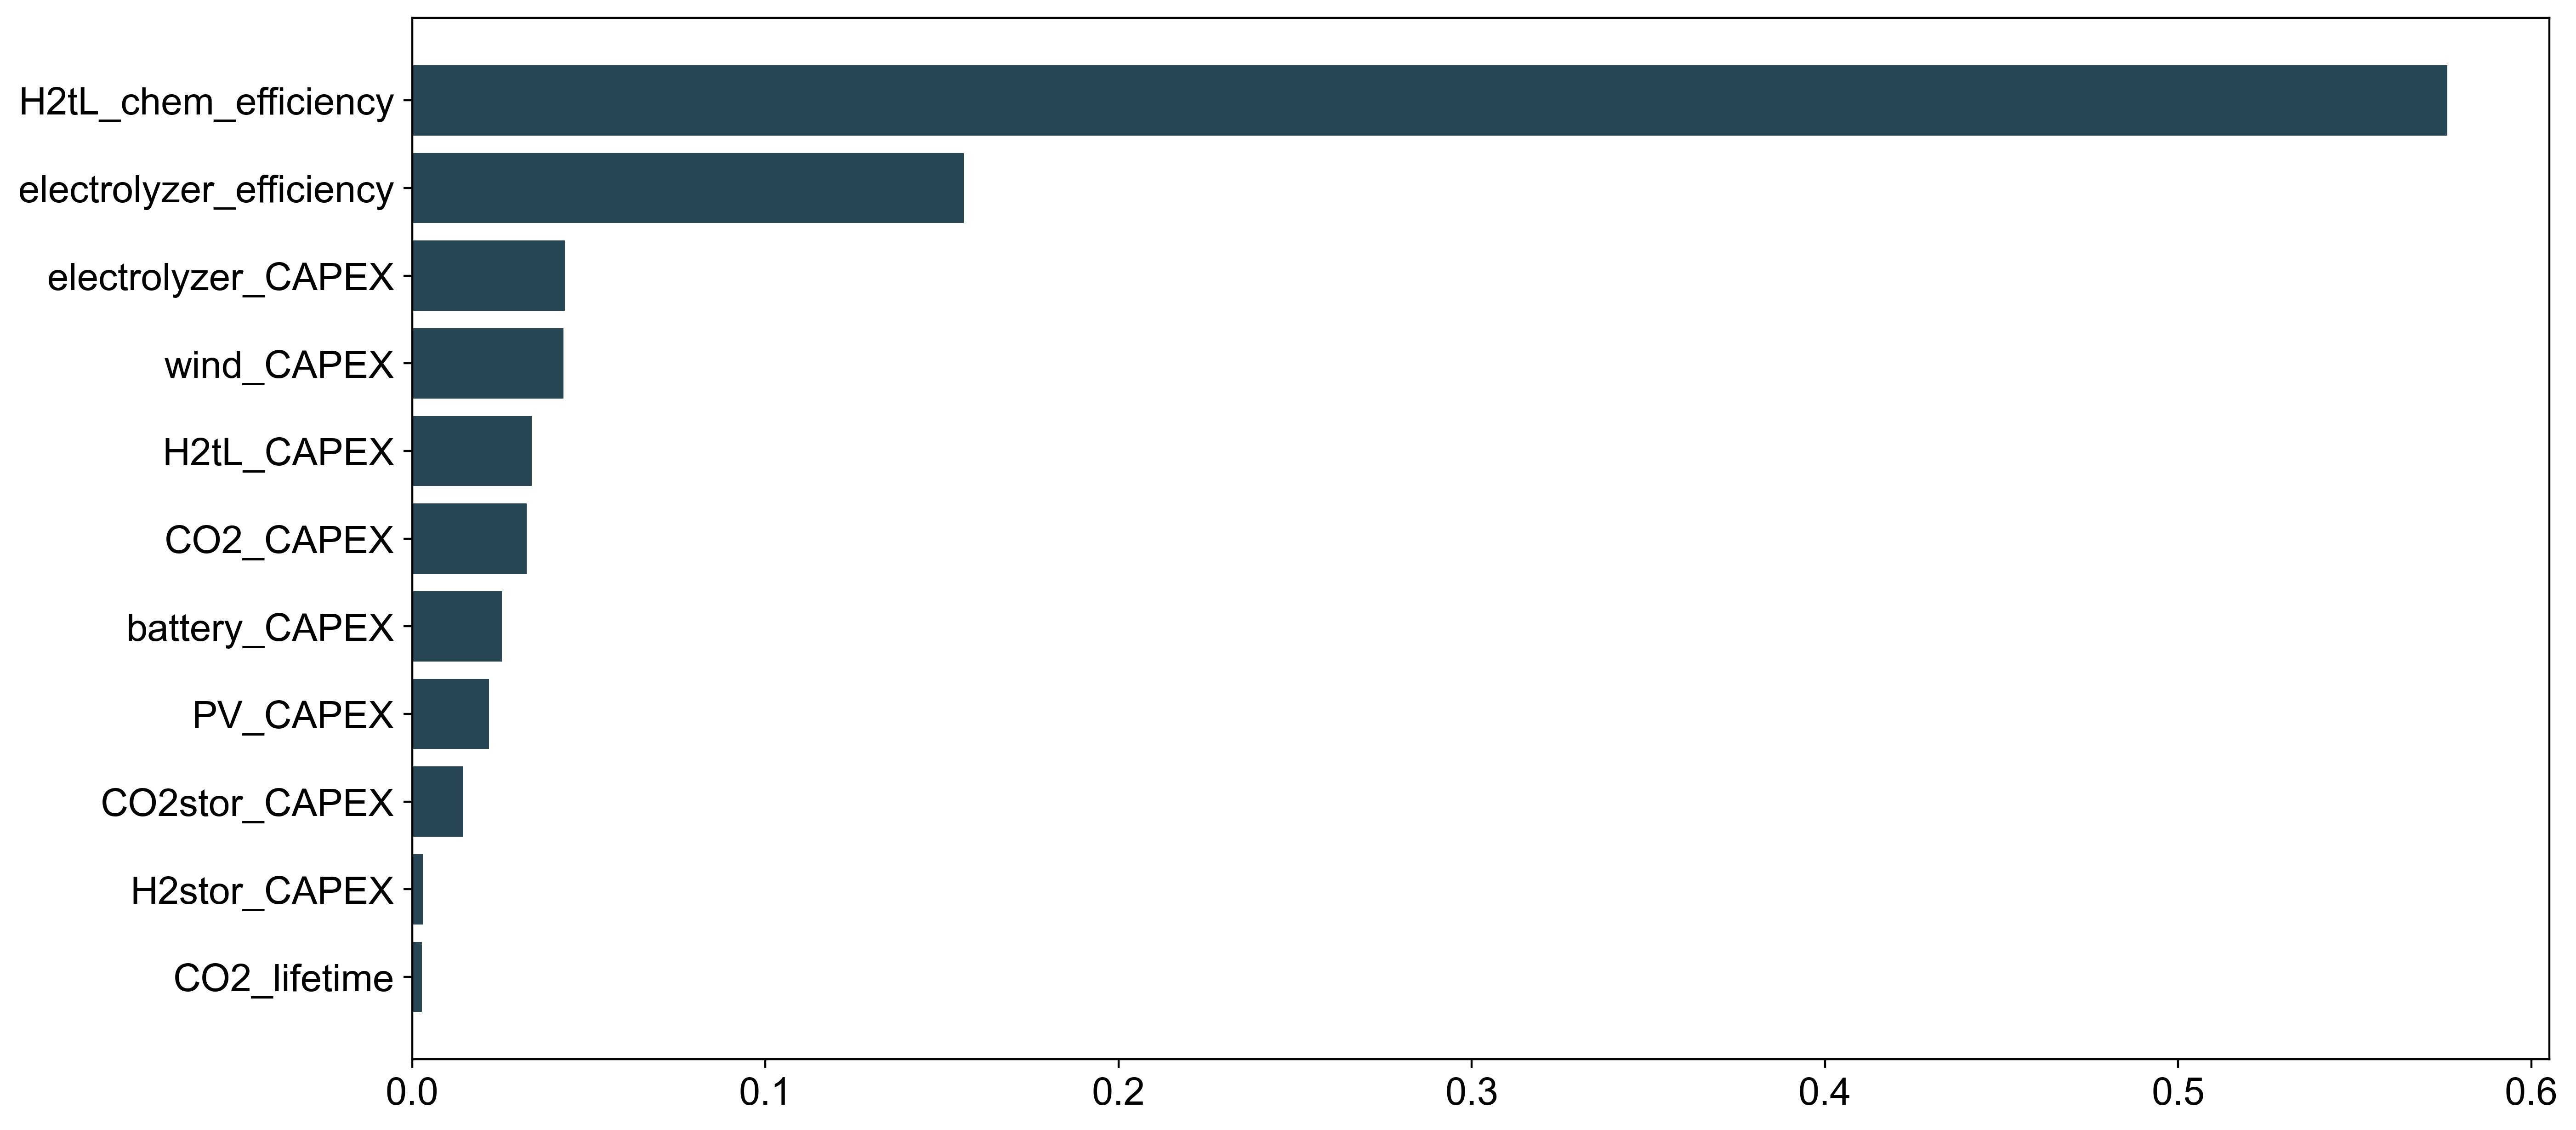

In [13]:
ols_reg_bar = ols_reg.sort_values('R-Squared',ascending=True)
plt.barh(ols_reg_bar.Parameter, ols_reg_bar['R-Squared'], );

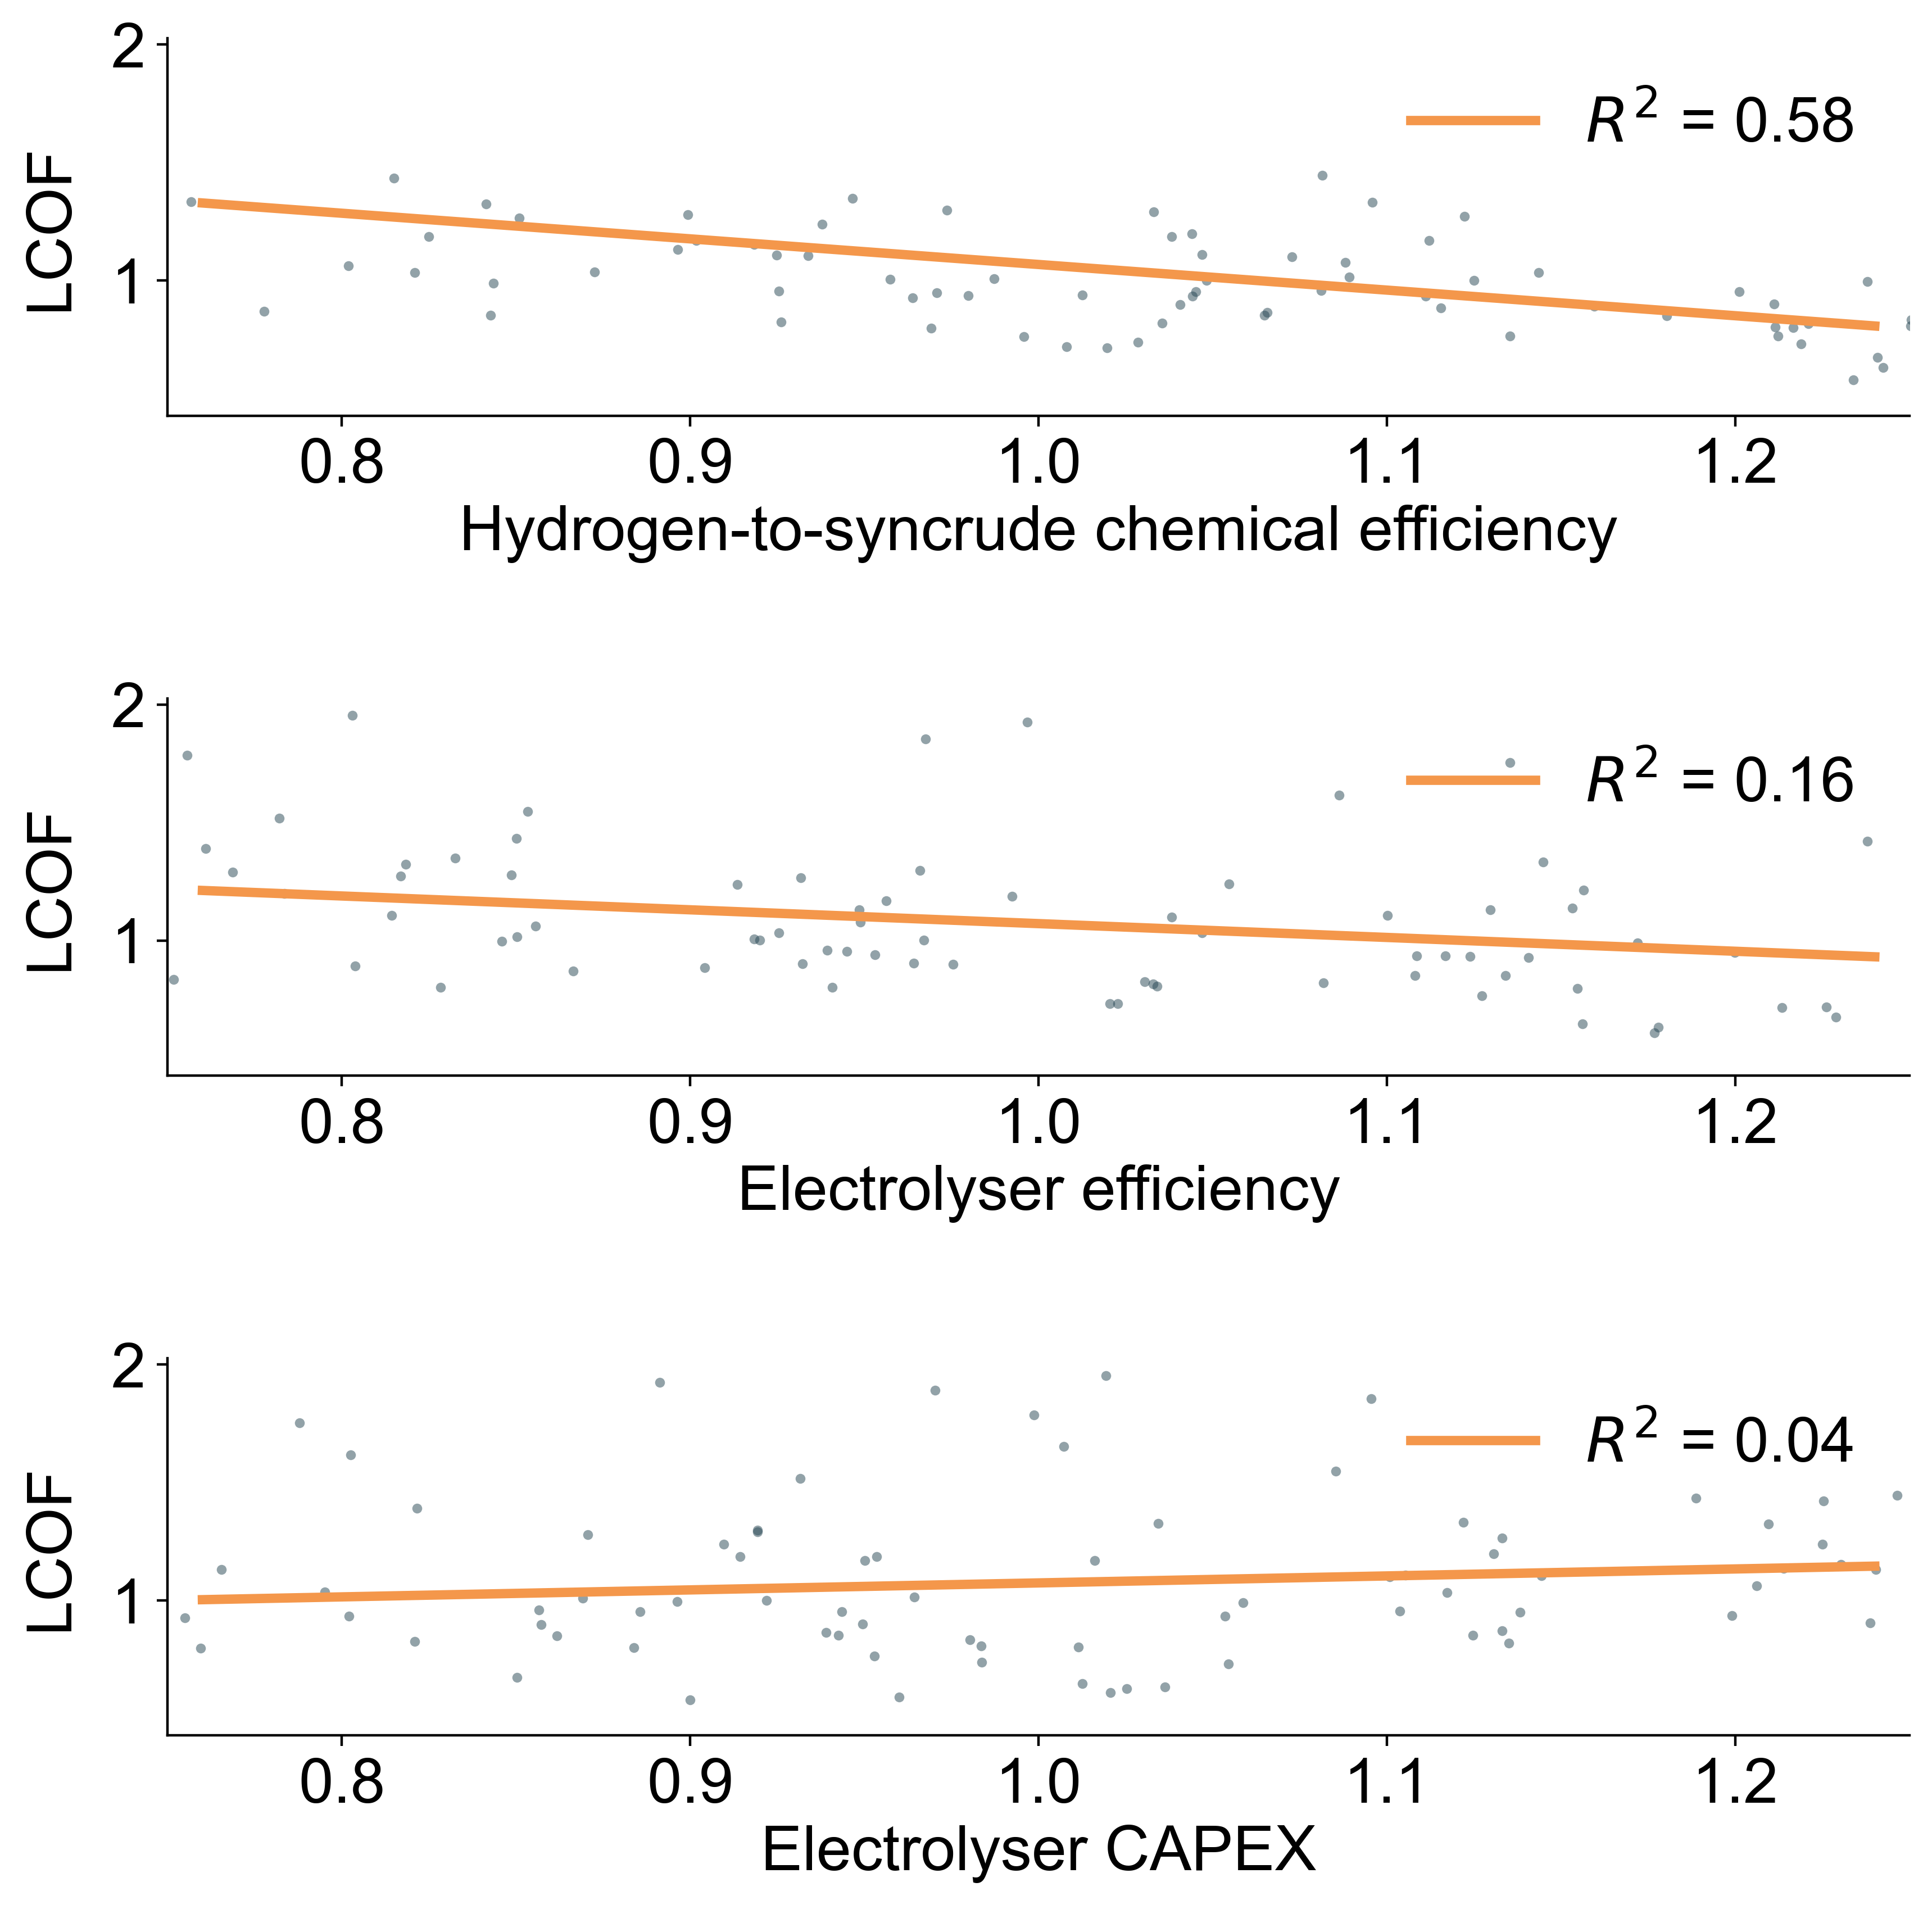

In [14]:
figsize=(10,10)
fontsize=figsize[0]*2
params_count = 3
ncols=1
df = combined_gdf.copy()
ols_reg_slice = ols_reg.loc[ols_reg.Parameter!='discount_rate'].sort_values('R-Squared',ascending=False).iloc[:params_count].reset_index(drop=True).copy()

cmap = 'RdYlGn_r'

titles = {
    'H2tL_chem_efficiency':'Hydrogen-to-syncrude chemical efficiency',
    'electrolyzer_efficiency': 'Electrolyser efficiency',
    'wind_CAPEX': 'Wind turbine CAPEX',
    'electrolyzer_CAPEX': 'Electrolyser CAPEX'
}

if ncols == None:
    ncols = int(np.ceil(np.sqrt(params_count)))
nrows = int(np.ceil(params_count/ncols))    
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for idx,row in ols_reg_slice.iterrows():
    axes[idx].scatter(df[row.Parameter],df.LCOF_liter_norm, s=10, alpha=0.5, lw=0)#, cmap=cmap, vmin=2, vmax=4, c=df.LCOF_liter_2020)
    minx = 0.75
    maxx = 1.25
    x = np.linspace(0.76,1.24,100)
    y = row.Slope*x + row.Intercept
    axes[idx].plot(x,y,linewidth=3,color='C1',label=fr'$R^{2}$ = {row["R-Squared"]:.2f}')
    axes[idx].set_xlabel(titles[row.Parameter],fontsize=fontsize, labelpad=3)
    axes[idx].tick_params(labelsize=fontsize)
    axes[idx].legend(fontsize=fontsize,framealpha=0, loc='upper right')
    if idx in [x*ncols for x in range(nrows)]:
        axes[idx].set_ylabel('LCOF',labelpad=10,fontsize=fontsize)
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].set_xlim(minx,maxx)
plt.subplots_adjust(hspace=0.75)
# plt.savefig('../../gfx/highest_sensitivities.png',dpi=400,bbox_inches='tight')

# LCOF Distribution

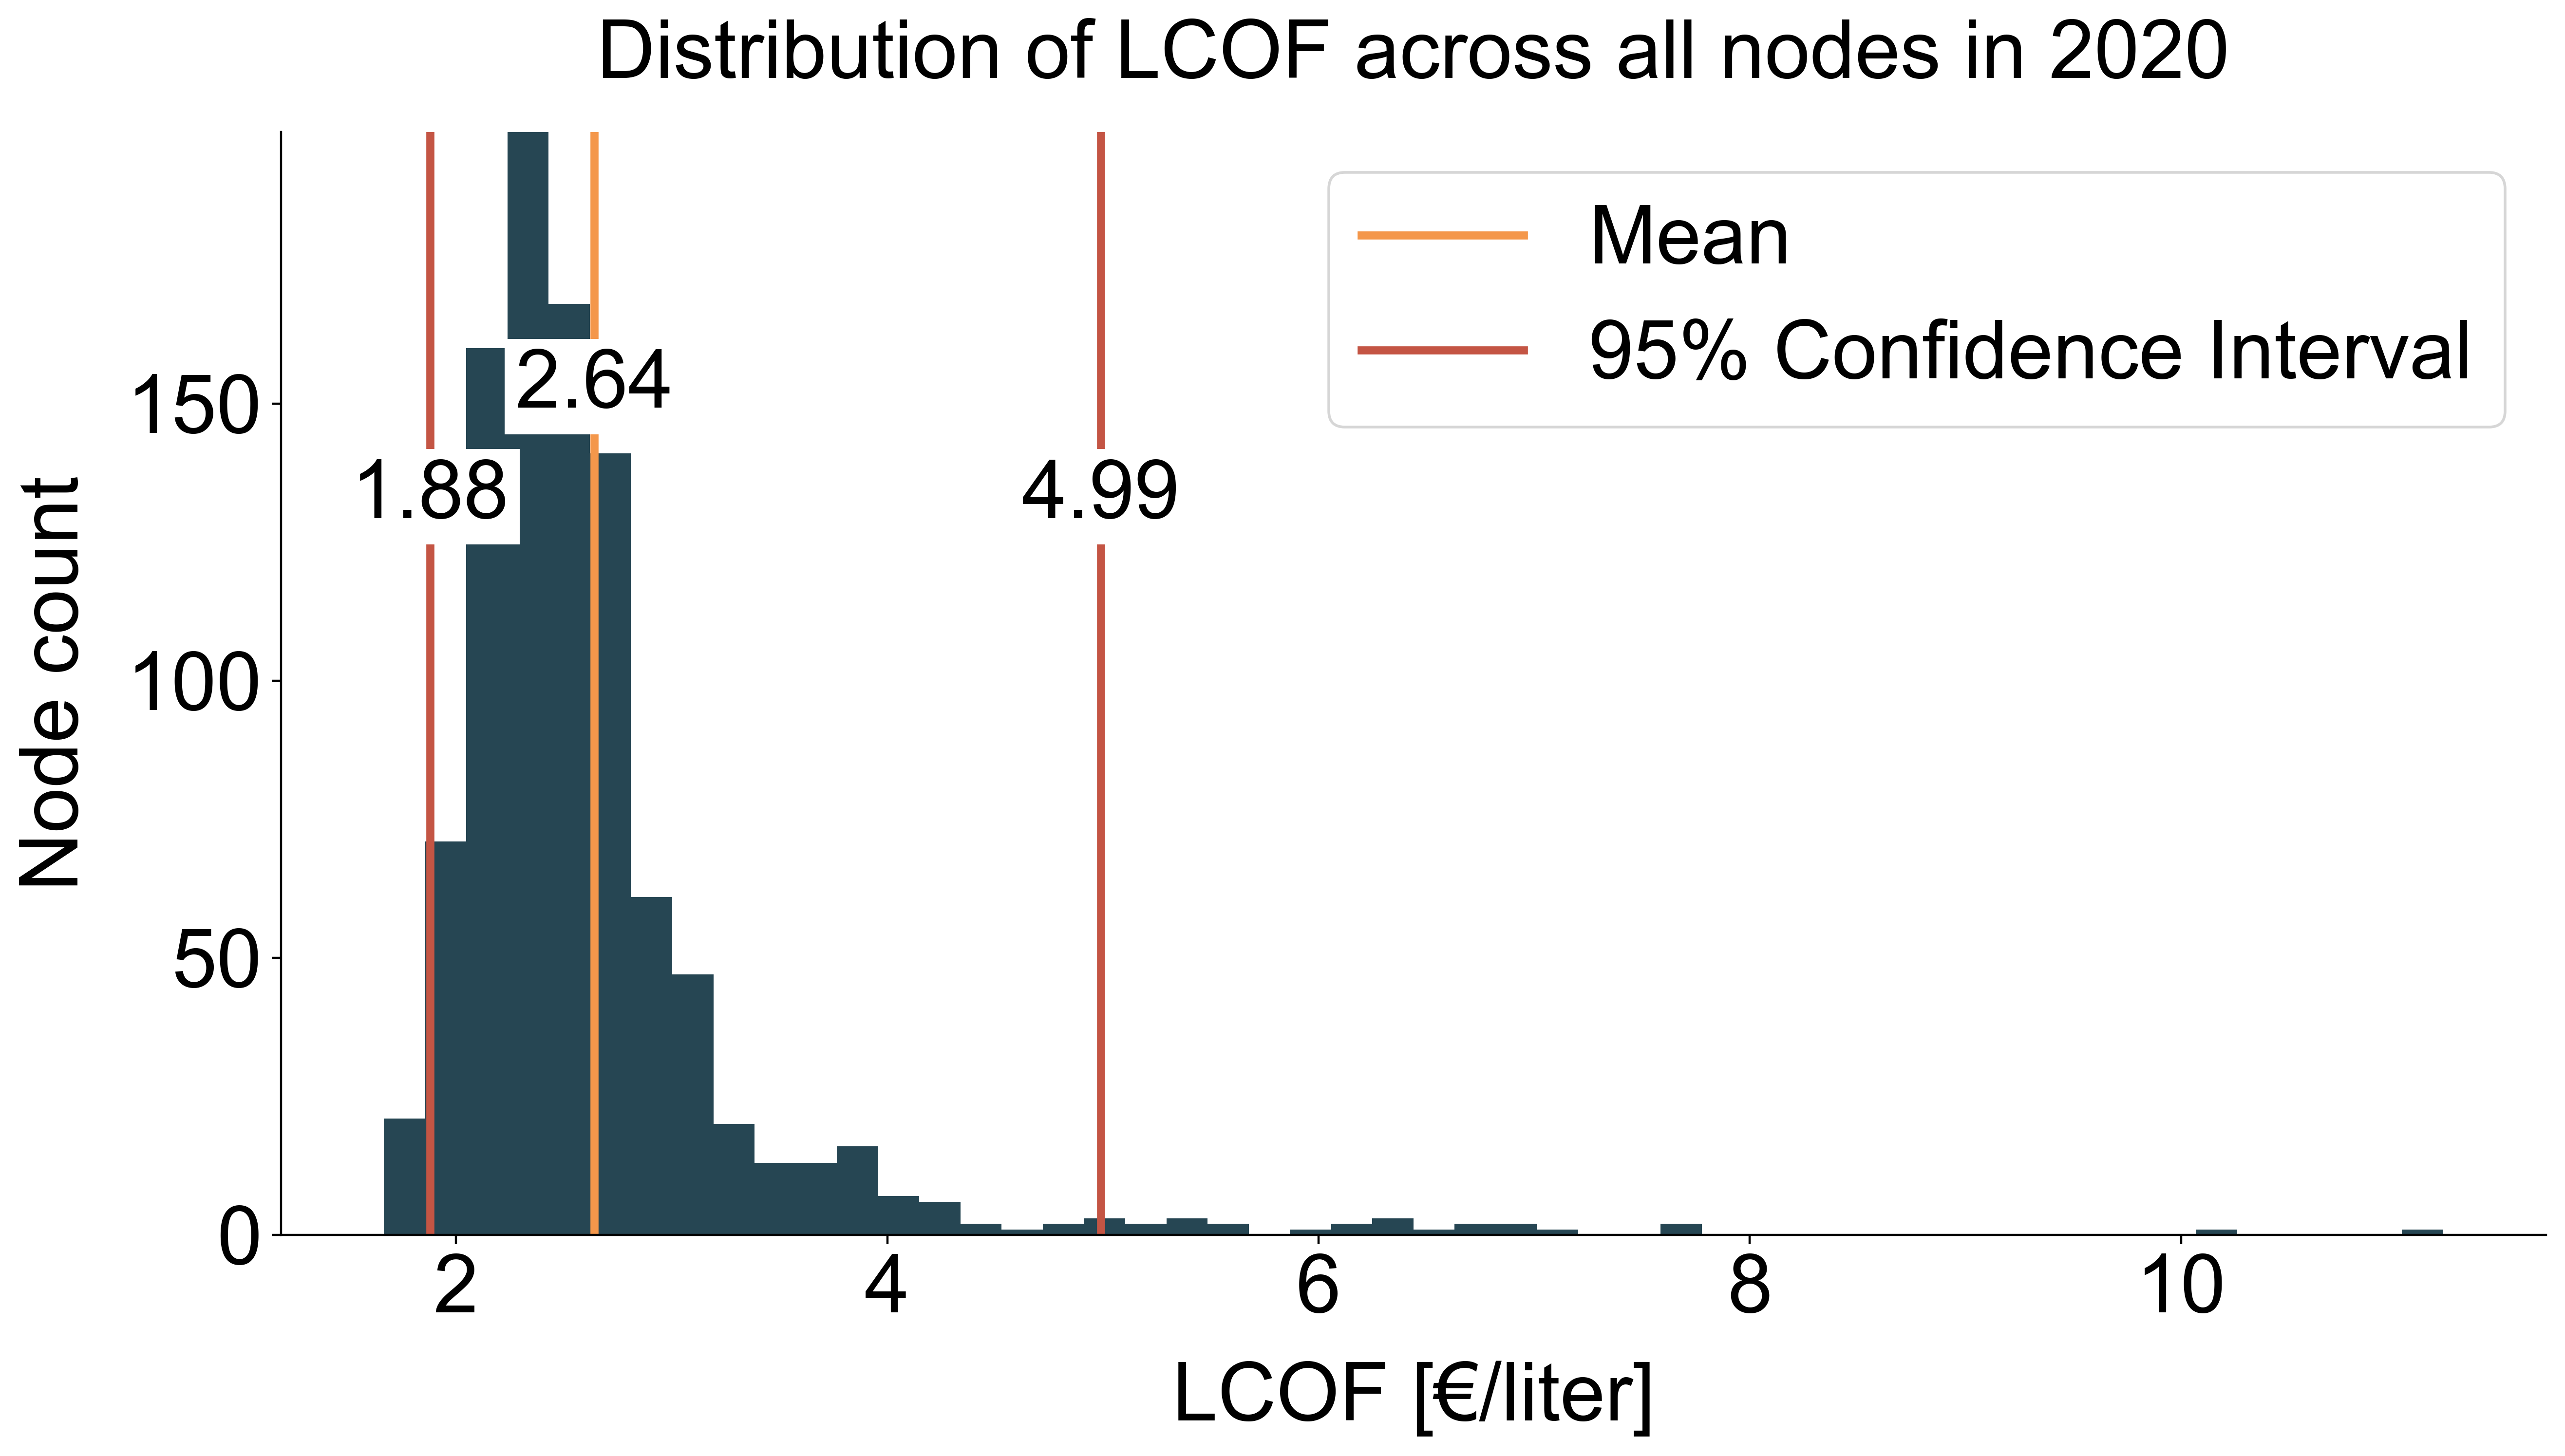

In [17]:
figsize=(15,7.5)
ymax = 199
plt.figure(figsize=figsize)
fontsize=figsize[0]*2
ax = combined_gdf.LCOF_liter_sensi.hist(bins=50)
ax.axvline(combined_gdf.LCOF_liter_sensi.mean(), linewidth=3,c='C1',label='Mean')
ax.text(combined_gdf.LCOF_liter_sensi.mean(),ymax*0.75, round(combined_gdf.LCOF_liter_sensi.mean(),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.025),linewidth=3,c='C2',label='95% Confidence Interval')
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.025),ymax*0.65, round(combined_gdf.LCOF_liter_sensi.quantile(0.025),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.975),linewidth=3,c='C2',)
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.975),ymax*0.65, round(combined_gdf.LCOF_liter_sensi.quantile(0.975),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.set_xlabel('LCOF [€/liter]',fontsize=fontsize)
ax.set_ylabel('Node count',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=None)
ax.set_ylim(0,ymax)
ax.set_title('Distribution of LCOF across all nodes in 2020',fontsize=fontsize,pad=20)
ax.legend(fontsize=fontsize);

# plt.savefig('../../gfx/LCOF_distribution.png',dpi=400)

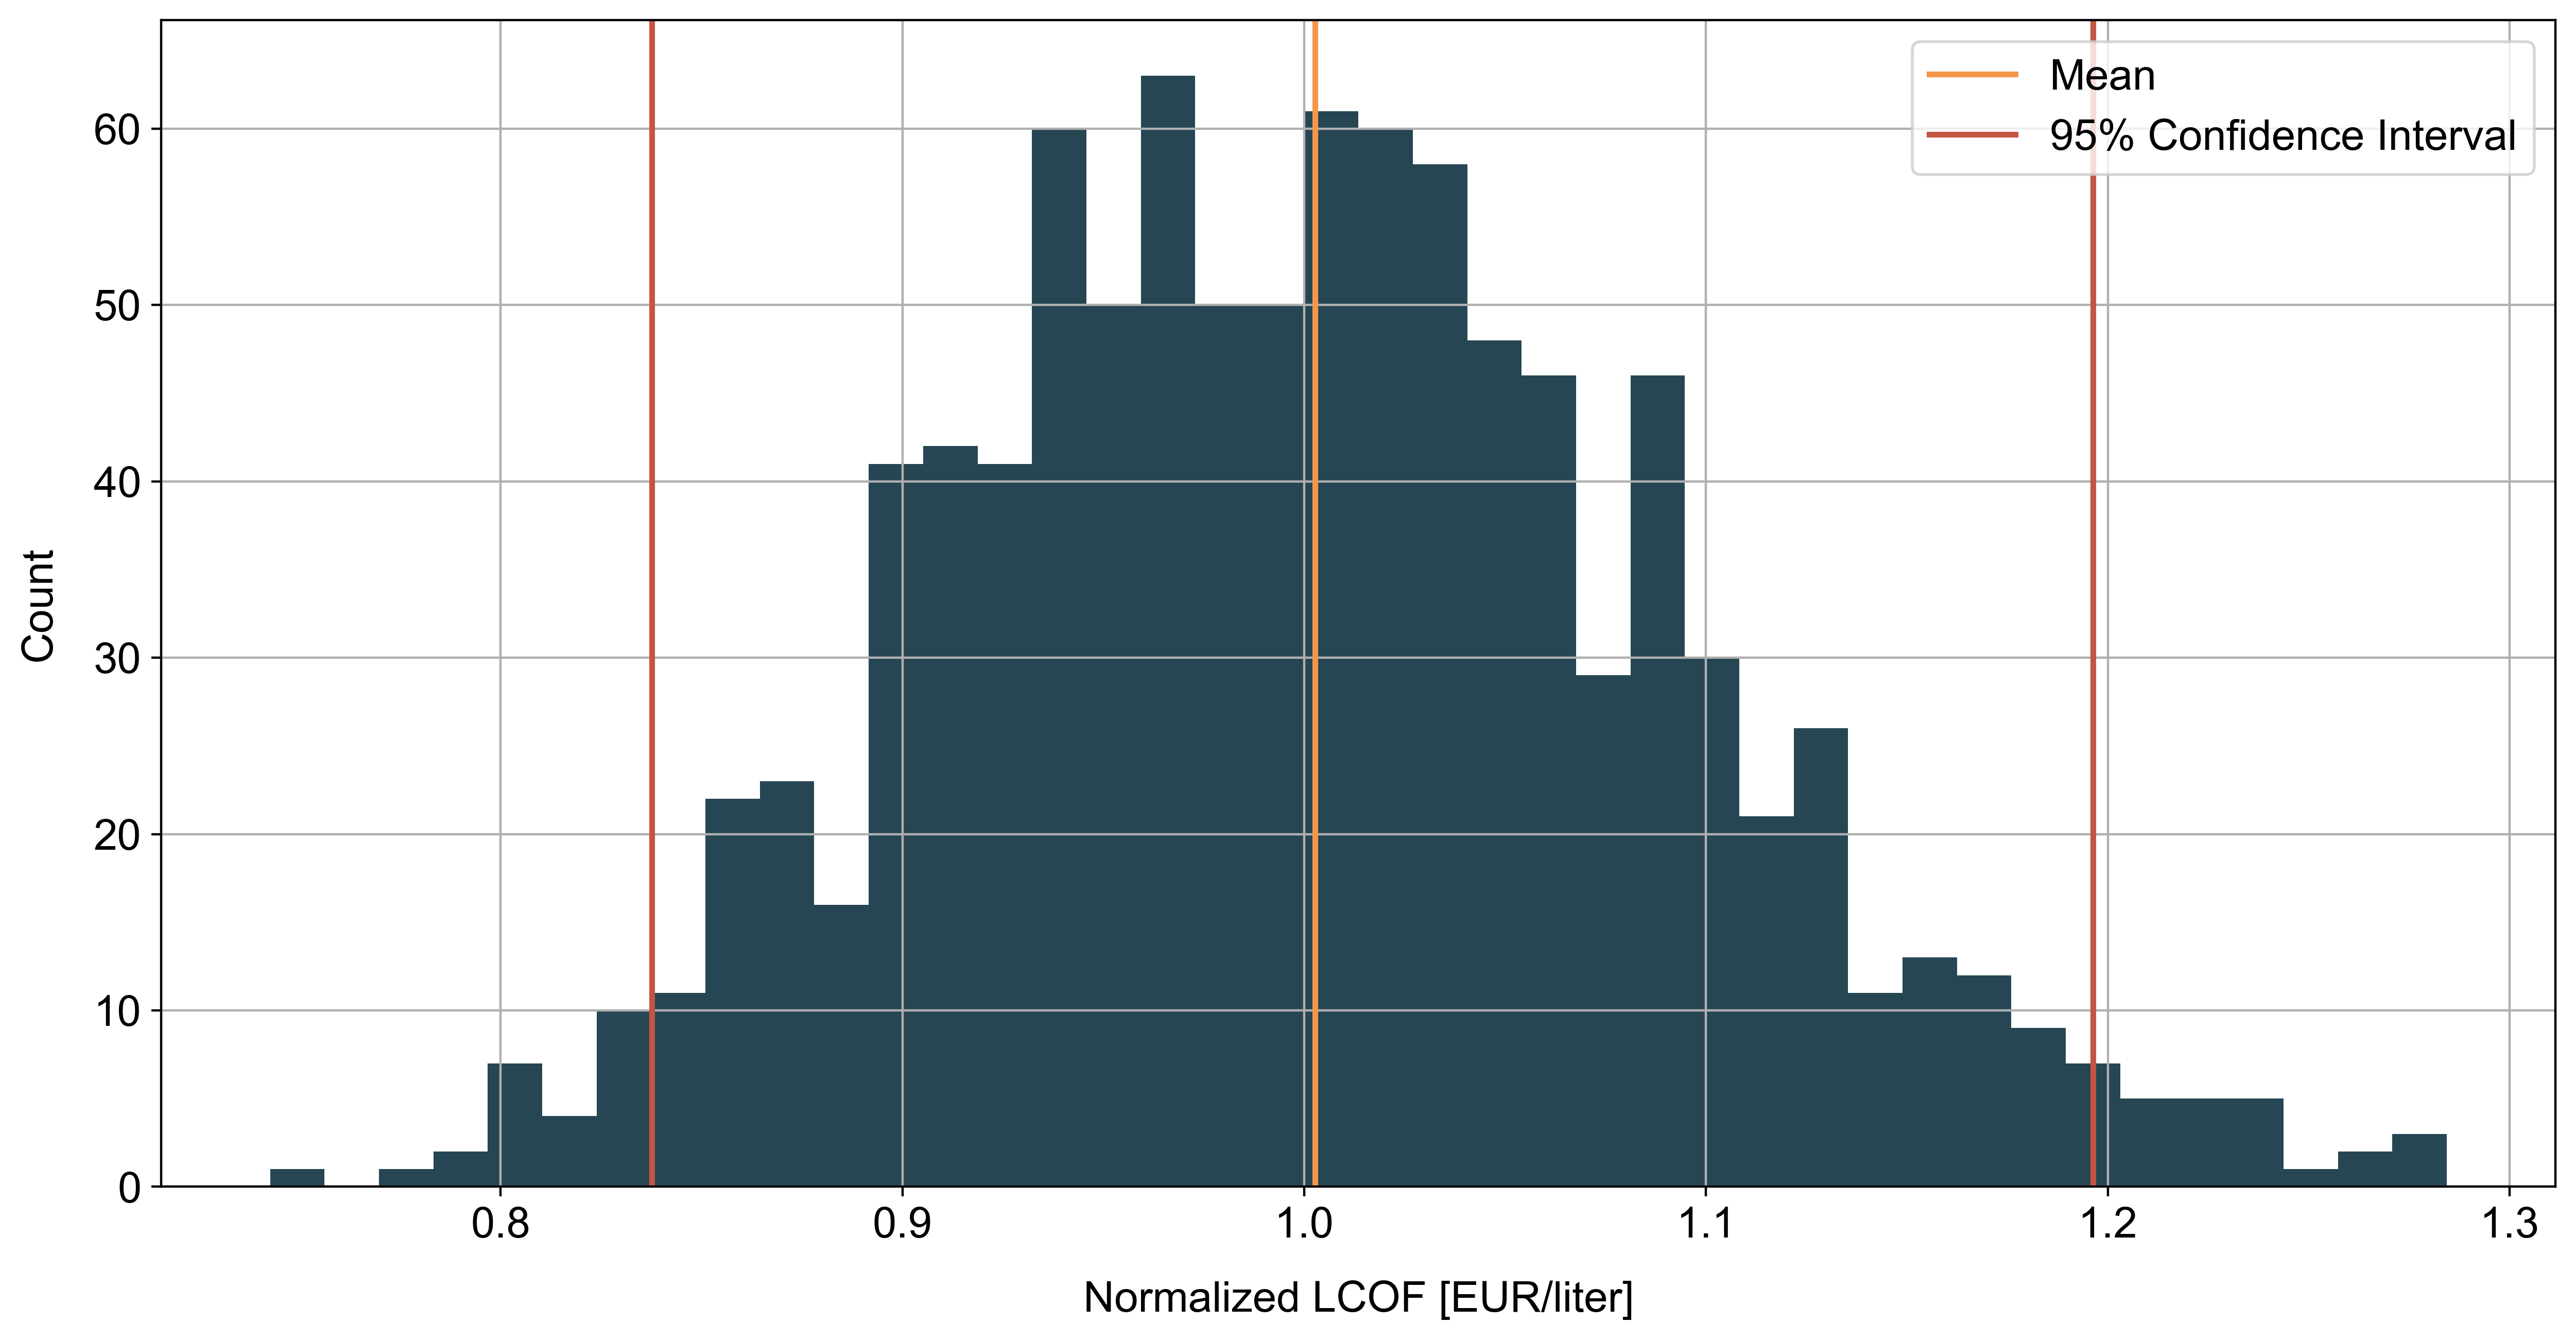

In [19]:
plt.figure(figsize=(15,7.5))
ax = combined_gdf.LCOF_liter_norm.hist(bins=40)
ax.axvline(combined_gdf.LCOF_liter_norm.mean(),c='C1',label='Mean')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.025),c='C2',label='95% Confidence Interval')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.975),c='C2',)
ax.set_xlabel('Normalized LCOF [EUR/liter]')
ax.set_ylabel('Count')
ax.legend();